# Exploration

This notebook is dedicated to exploring the SXSW Twitter dataset with an eye towards extracting brand-related sentiments.

## Bird's Eye View

I begin my exploratory analysis by trying to get an overall sense of what people were talking about regarding Apple and Google.

In [1]:
import json
from functools import partial
from os.path import normpath
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from tools import language as lang, plotting
from tools.sklearn.vectorizers import FreqVectorizer

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_json(normpath("data/processed_tweets.json"))
df.head()

,text,object_of_emotion,emotion,brand_terms,n_chars,n_words,avg_word_len,ep_count,qm_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,[iphone],104,29,3.586207,1,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iOS App,Positive,"[ipad, iphone_app]",118,26,4.538462,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,[ipad],65,17,3.823529,0,0
3,@sxsw I hope this year's festival isn't as cra...,iOS App,Negative,[iphone_app],68,16,4.250000,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,[google],115,27,4.259259,0,0


<IPython.core.display.Javascript object>

I load up the stopwords that I defined in the main notebook.

In [6]:
with open(normpath("data/stopwords.json"), "r") as f:
    stopwords = json.load(f)

MY_STOP = frozenset(stopwords["MY_STOP"])
BRAND_STOP = frozenset(stopwords["BRAND_STOP"])
del stopwords

MY_STOP, BRAND_STOP

(frozenset({'america',
            'austin',
            'link',
            'mention',
            'rt',
            'southbysouthwest',
            'sxsw',
            'sxswi'}),
 frozenset({'andoid',
            'android',
            'androidsxsw',
            'app',
            'apple',
            'applesxsw',
            'google',
            'ipad',
            'iphone'}))

<IPython.core.display.Javascript object>

I make a large set of all relevant stopwords to use later.

In [7]:
all_stop = (
    MY_STOP
    | BRAND_STOP
    | lang.fetch_stopwords("gensim_english | nltk_english | skl_english")
)

pprint(all_stop, compact=True, width=120)

frozenset({'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone',
           'along', 'already', 'also', 'although', 'always', 'am', 'america', 'among', 'amongst', 'amoungst', 'amount',
           'an', 'and', 'andoid', 'android', 'androidsxsw', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway',
           'anywhere', 'app', 'apple', 'applesxsw', 'are', 'aren', "aren't", 'around', 'as', 'at', 'austin', 'back',
           'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind',
           'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call',
           'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldn', "couldn't", 'couldnt', 'cry', 'd', 'de',
           'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't",
           'done', 'down', 'due', 'during', 'each', 'e

<IPython.core.display.Javascript object>

### Text Cleaning

I do some basic preprocessing on the text using functions from my `tools.language` module. Most are wrappers around functions from `gensim`, `nltk`, `sklearn`, or `sacremoses`.

In [9]:
filts = [
    lang.lowercase,
    lang.decode_html_entities,
    lang.uni2ascii,
    # Tokenize with MosesTokenizer
    lang.moses_tokenize,
    lang.filter_length,
    lang.wordnet_lemmatize,
    # Detokenize with MosesDetokenizer
    lang.moses_detokenize,
    lang.strip_multiwhite,
]

# Start with raw text
clean_text = df["text"].copy()

# Apply `filts` in sequence
for filt in filts:
    clean_text = clean_text.map(filt)

clean_text

0       wesley83 have iphone. after hr tweet rise aust...
1       jessedee know about fludapp awesome ipad iphon...
2       swonderlin can not wait for ipad also. they sh...
3       sxsw hope this year's festival isn't crashy th...
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
9088                            ipad everywhere sxsw link
9089    wave buzz... mention interrupt your regularly ...
9090    google's zeiger physician never report potenti...
9091    some verizon iphone customer complain their ti...
9092         mention google test check-in offer sxsw link
Name: text, Length: 8879, dtype: object

<IPython.core.display.Javascript object>

In [10]:
# Get indices for each major brand
apple_indices = df["object_of_emotion"] == "Apple"
google_indices = df["object_of_emotion"] == "Google"

# Slice out tweets for each category
apple_tweets = clean_text.loc[apple_indices]
google_tweets = clean_text.loc[google_indices]

apple_tweets.head(10)

9      count down the day sxsw plus strong canadian d...
40     mention great weather greet you for sxsw still...
47     hooray mention apple open pop-up store austin ...
49     wooooo mention apple store downtown austin ope...
62     omfg mention heard about apple's pop-up store ...
64        again mention line the apple store insane sxsw
83     nice mention hey apple fan get peek the space ...
109    kawasaki "not c.s. lewis level reason but appl...
111    kawasaki "pagemaker save apple" those be the d...
116          sxsw apple school the marketing expert link
Name: text, dtype: object

<IPython.core.display.Javascript object>

### Apple's Pop-up Store
Many of the quadgrams (according to the 'likelihood_ratio' metric) are about Apple's pop-up store where the iPad 2 is being launched. [This article](https://money.cnn.com/2011/03/11/technology/ipad_2_launch/index.htm) describes the crowd swarming for the launch. Also this sentence seems to be popular:

> "Apple comes up with cool technology no one's ever heard of because they don't go to conferences."

In [11]:
apple_quad = lang.scored_quadgrams(
    apple_tweets,
    measure="likelihood_ratio",
    tokenizer=nltk.word_tokenize,
    stopwords=MY_STOP,
    min_freq=5,
)

apple_quad.head(20)

quadgram
open temporary store downtown    2295.082375
before even begin apple          2213.452611
they do n't conference           2171.721602
apple open temporary store       2168.695817
because they do n't              2129.865829
ever heard because they          2106.922095
even begin apple win             2106.599585
do n't conference ''             2072.394619
heard because they do            2022.470354
apple open pop-up store          2007.054865
's ever heard because            1993.209972
one 's ever heard                1971.075873
technology one 's ever           1951.560723
with cool technology one         1875.898992
come with cool technology        1861.574914
cool technology one 's           1849.118711
open temporary store for         1808.062120
set open pop-up store            1734.230995
temporary store downtown for     1664.695993
open pop-up store for            1619.779877
Name: score, dtype: float64

<IPython.core.display.Javascript object>

### Google Circles
The top quadrams about Google all have to do with the anticipated Google Circles launch.

In [12]:
google_quad = lang.scored_quadgrams(
    google_tweets,
    measure="likelihood_ratio",
    tokenizer=nltk.word_tokenize,
    stopwords=MY_STOP,
    min_freq=5,
)
google_quad.head(20)

quadgram
new social network call          1965.108730
major new social network         1863.129998
social network call circle       1767.115459
launch major new social          1555.393080
network call circle possibly     1532.758333
launch new social network        1470.993319
call circle possibly today       1424.676973
google 's marissa mayer          1342.421033
google launch major new          1138.660205
before you tweet ''              1136.659844
before you speak ''              1101.139695
`` think before you              1082.316054
marissa mayer google will        1075.673730
think before you speak            974.825066
`` google before you              935.074099
google launch new social          925.536997
mark belinsky 911tweets panel     896.482685
google before you tweet           856.241277
'' mark belinsky 911tweets        830.364612
new `` think before               826.716098
Name: score, dtype: float64

<IPython.core.display.Javascript object>

There is no glaringly obvious pattern in the counts of 'Negative' and 'Positive' tweets for each brand. Talk about the new iPad leads in both the 'Negative' and 'Positive' categories, whereas Google leads in the 'Neutral' category.

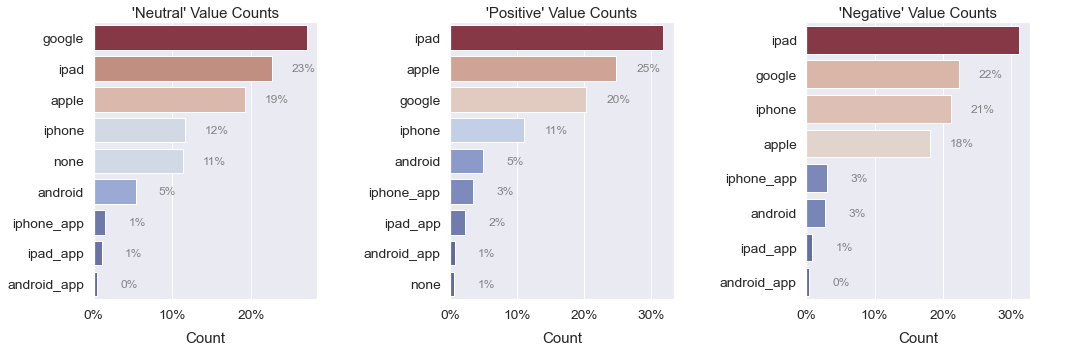

<IPython.core.display.Javascript object>

In [13]:
fig = plotting.countplot(
    df.explode("brand_terms").groupby("emotion")["brand_terms"],
    normalize=True,
)

A color palette for the sentiment classes.

In [14]:
emo_pal = dict(Negative="r", Neutral="gray", Positive="g")
emo_pal

{'Negative': 'r', 'Neutral': 'gray', 'Positive': 'g'}

<IPython.core.display.Javascript object>

It's fascinating how robust of a connection there is between exclamation points and positive sentiment. This is interesting to note for future sentiment analysis work.

Question marks are also pretty robustly non-positive. That makes sense intuitively.

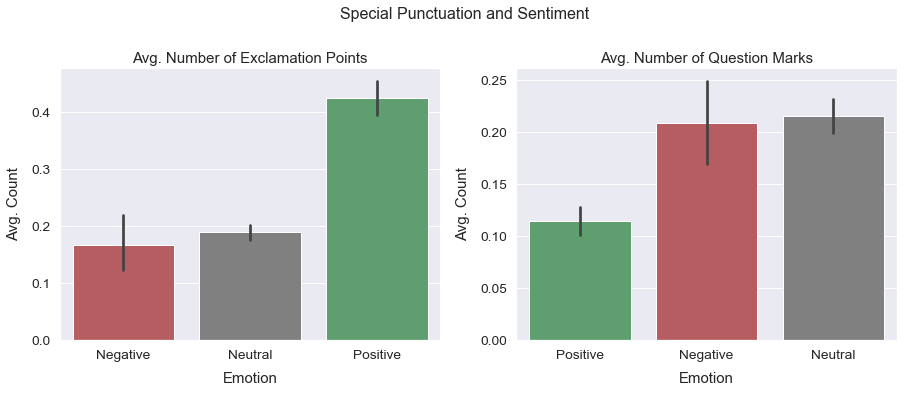

<IPython.core.display.Javascript object>

In [15]:
# Create plot objects
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

# Plot exclamation points on `ax1`
plotting.barplot(
    data=df,
    x="emotion",
    y="ep_count",
    palette=emo_pal,
    ax=ax1,
)

# Plot question marks on `ax2`
plotting.barplot(
    data=df,
    x="emotion",
    y="qm_count",
    palette=emo_pal,
    ax=ax2,
)

# Set `ax1` title and labels
ax1.set(
    title="Avg. Number of Exclamation Points",
    xlabel="Emotion",
    ylabel="Avg. Count",
)

# Set `ax2` title and labels
ax2.set(
    title="Avg. Number of Question Marks",
    xlabel="Emotion",
    ylabel="Avg. Count",
)

fig.suptitle("Special Punctuation and Sentiment", fontsize=16, y=1.05)

fig.savefig(normpath("images/punct_sentiment.svg"), bbox_inches="tight")

## Keywords by Brand

I construct "superdocuments" by grouping by 'emotion' and 'object_of_emotion' and concatenating the raw tweets in each group. Every brand/product will have 2 superdocuments: positive and negative.

In [16]:
brand_docs = (
    # Get Series where each value is a list of row indices
    pd.Series(df.groupby(["emotion", "object_of_emotion"]).groups)
    # Replace lists of row indices with sliced out tweets
    .map(lambda x: df.loc[x, "text"])
    # Fuse the tweets together
    .map(lambda x: " ".join(x))
)
# Get rid of Neutral group and swap index levels
brand_docs = brand_docs.drop(index=np.nan, level=1).swaplevel(0, 1)
brand_docs

Android               Negative    they took away the lego pit but replaced it wi...
Android App           Negative    Beware, the android #sxsw app for schedules is...
Apple                 Negative    Again? RT @mention Line at the Apple store is ...
Google                Negative    @mention  - False Alarm: Google Circles Not Co...
Other Apple Product   Negative    @mention I meant iTunes doesn't work for me (I...
Other Google Product  Negative    ���@mention Google to Launch Major New Social ...
iOS App               Negative    @sxsw I hope this year's festival isn't as cra...
iPad                  Negative    attending @mention iPad design headaches #sxsw...
iPhone                Negative    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
Android               Positive    #SXSW is just starting, #CTIA is around the co...
Android App           Positive    Find &amp; Start Impromptu Parties at #SXSW Wi...
Apple                 Positive    Counting down the days to #sxsw plus stron

<IPython.core.display.Javascript object>

Now I use my `FreqVectorizer` to extract tf-idf vectors for each superdocument. Each document is transformed into a vector of TF-IDF scores where the features are words. For each term in each superdocument, the score is (roughly) the term's local frequency times a measure of its rarity in the corpus as a whole. I set the 'max_df' to 0.3, meaning that terms which occur in more than 30% of the documents are excluded. This separates the wheat from the chaff.

See the main notebook for an overview of my `FreqVectorizer` class, which extends Scikit-Learns `TfidfVectorizer`.

In [27]:
# Make vectorizer
tfidf = FreqVectorizer(
    tokenizer=nltk.word_tokenize,
    strip_accents="ascii",
    filter_length=(2, 15),
    alphanum_only=True,
    stop_words=all_stop,
    ngram_range=(1, 2),
    norm="l2",
    use_idf=True,
    max_df=0.3,
)

# Make vectors
brand_vecs = tfidf.fit_transform(brand_docs.values)

# Place vectors in DataFrame
brand_vecs = lang.frame_doc_vecs(
    brand_vecs,
    tfidf.vocabulary_,
    brand_docs.index,
)

# Transpose so that vectors run along columns
brand_vecs = brand_vecs.T.sort_index(level=0, axis=1)

# Sort for effect
brand_vecs.sort_values(("Apple", "Negative"), ascending=False)

Android          Android App              Apple            \
                   Negative Positive    Negative Positive  Negative  Positive   
fascist                 0.0      0.0         0.0      0.0  0.308758  0.000000   
fascist company         0.0      0.0         0.0      0.0  0.264650  0.000000   
classiest               0.0      0.0         0.0      0.0  0.198487  0.000000   
pop                     0.0      0.0         0.0      0.0  0.190065  0.437579   
swisher                 0.0      0.0         0.0      0.0  0.176433  0.000000   
...                     ...      ...         ...      ...       ...       ...   
getting great           0.0      0.0         0.0      0.0  0.000000  0.000000   
getting finals          0.0      0.0         0.0      0.0  0.000000  0.000000   
getting essentials      0.0      0.0         0.0      0.0  0.000000  0.000000   
getting envy            0.0      0.0         0.0      0.0  0.000000  0.000000   
zzzs battery            0.0      0.0         0.0      0.0  0.000000  0.000000   

                     Google           Other Apple Product           \
                   Negative  Positive            Negative Positive   
fascist                 0.0  0.000000                 0.0      0.0   
fascist company         0.0  0.000000                 0.0      0.0   
classiest               0.0  0.000000                 0.0      0.0   
pop                     0.0  0.000000                 0.0      0.0   
swisher                 0.0  0.000000                 0.0      0.0   
...                     ...       ...                 ...      ...   
getting great           0.0  0.007517                 0.0      0.0   
getting finals          0.0  0.000000                 0.0      0.0   
getting essentials      0.0  0.000000                 0.0      0.0   
getting envy            0.0  0.000000                 0.0      0.0   
zzzs battery            0.0  0.000000                 0.0      0.0   

                   Other Google Product           iOS App               iPad  \
                               Negative Positive Negative Positive  Negative   
fascist                             0.0      0.0      0.0      0.0  0.000000   
fascist company                     0.0      0.0      0.0      0.0  0.000000   
classiest                           0.0      0.0      0.0      0.0  0.000000   
pop                                 0.0      0.0      0.0      0.0  0.068342   
swisher                             0.0      0.0      0.0      0.0  0.000000   
...                                 ...      ...      ...      ...       ...   
getting great                       0.0      0.0      0.0      0.0  0.000000   
getting finals                      0.0      0.0      0.0      0.0  0.000000   
getting essentials                  0.0      0.0      0.0      0.0  0.000000   
getting envy                        0.0      0.0      0.0      0.0  0.000000   
zzzs battery                        0.0      0.0      0.0      0.0  0.000000   

                                iPhone           
                    Positive  Negative Positive  
fascist             0.000000  0.000000      0.0  
fascist company     0.000000  0.000000      0.0  
classiest           0.000000  0.000000      0.0  
pop                 0.360394  0.000000      0.0  
swisher             0.000000  0.000000      0.0  
...                      ...       ...      ...  
getting great       0.000000  0.000000      0.0  
getting finals      0.006517  0.000000      0.0  
getting essentials  0.006517  0.000000      0.0  
getting envy        0.006517  0.000000      0.0  
zzzs battery        0.000000  0.025535      0.0  

[23724 rows x 18 columns]

<IPython.core.display.Javascript object>

In [28]:
def plot_brand_clouds(
    column,
    dst,
    cmap=("Reds", "Greens"),
    size=(10, 4),
    ncols=1,
    max_font_size=110,
    random_state=156,
    brand_vecs=brand_vecs,
    **kwargs,
):
    fig = plotting.wordcloud(
        brand_vecs.loc[:, column],
        cmap=list(cmap),
        size=size,
        ncols=ncols,
        max_font_size=max_font_size,
        random_state=random_state,
        **kwargs,
    )
    fig.savefig(normpath(dst))
    return fig

<IPython.core.display.Javascript object>

### Apple

Here is one of the most striking Wordclouds in the notebook. It reveals that people were talking about Apple being a "fascist company". This began with tech journalist [Kara Swisher](https://en.wikipedia.org/wiki/Kara_Swisher), who provoked a flurry of tweets by saying that Apple was the "classiest fascist company in America".

On the positive side, a lot of people were talking about the pop-up store and circulating the following quote:

> apple comes up with cool technology no one's ever heard of because they don't go to conferences

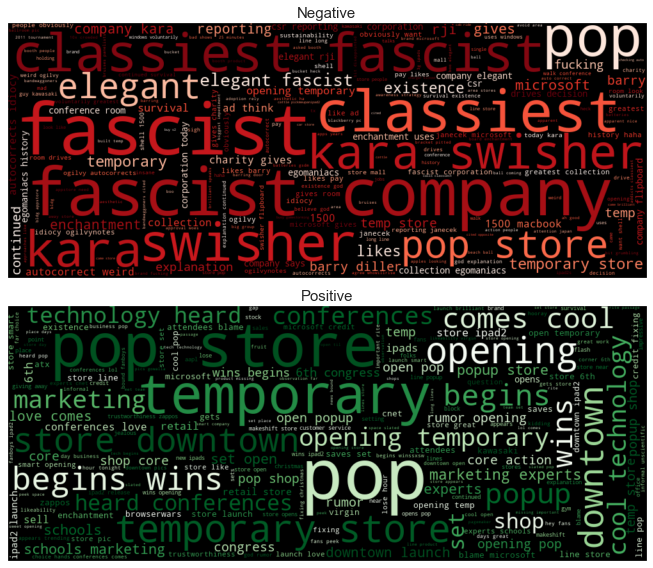

<IPython.core.display.Javascript object>

In [29]:
fig = plot_brand_clouds("Apple", "images/apple_clouds.svg")

### iPhone

Regarding the negative, there was a tweet bragging about T-Mobile, retweeted a few times:

> Looking forward to delicious T-Mobile 4G here in Austin while iPhone users struggle to do anything. #SXSW

There were similar remarks about AT&T's service making iPhone's useless as a brick:
> Austin is getting full, and #SXSW is underway. I can tell because my iPhone is an intermittent brick. #crowded

> Decided to go to LA instead of #SXSW, because my AT&T iPhone would be about as useful as a brick in Austin.

There was also talk about battery life problems.

> #sxsw is exposing my iphone's horrendous battery life.

> This #SXSW I am grateful for: my bicycle, having a back-up Twitter app. Cursing: losing an hour of zzzs, iPhone battery life.

> Disgusted with my iPhone's battery life. Already down to 11% at 3:30 pm while my blackberry is going strong. #Sxsw

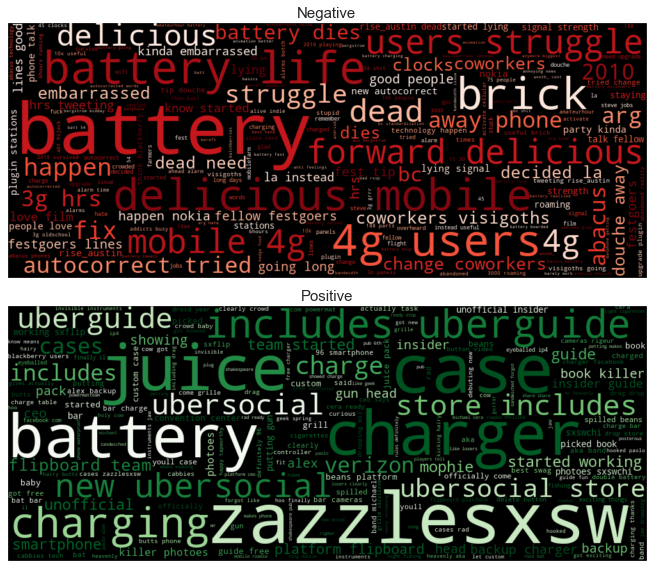

<IPython.core.display.Javascript object>

In [30]:
fig = plot_brand_clouds("iPhone", "images/iphone_clouds.svg")

Many positive tweets seem to be about how glad people are to have a charger.

The positive chatter about [Flipboard](https://flipboard.com/) was related to its well-designed iPad app.

> Epicurious, flipboard, CNN, wired, and MOMA as examples of good iPad design #SXSW {link}

The talk about [Zazzle](https://www.zazzle.com/) was related to designing custom iPhone cases, a service they offer.

> Zazzle is gearing up to hit #SXSW! Look out for our tweets on where you can come by to create your own iPhone case! #zazzlesxsw

There are some positive tweets about the newly-available **Verizon iPhones** and their superior service.

### iPad
The talk about "design headaches" is related to a talk given by Josh Clark on the topic of iPad design challenges and failings. It seems like constructive criticism which is not intended to harm the brand.

The talk about "japan relief" has to do with the following virally circulated quote:

> Best thing I've heard this weekend at #SXSW "I gave my iPad 2 money to #Japan relief. I don't need an iPad 2."

The quote expresses a definite negative attitude towards Apple and iPad, which it implies are associated with self-indulgence and excess.

The positive chatter is again focused on the pop-up store, with words like "shiny", "gadget", and "envy" showing up.

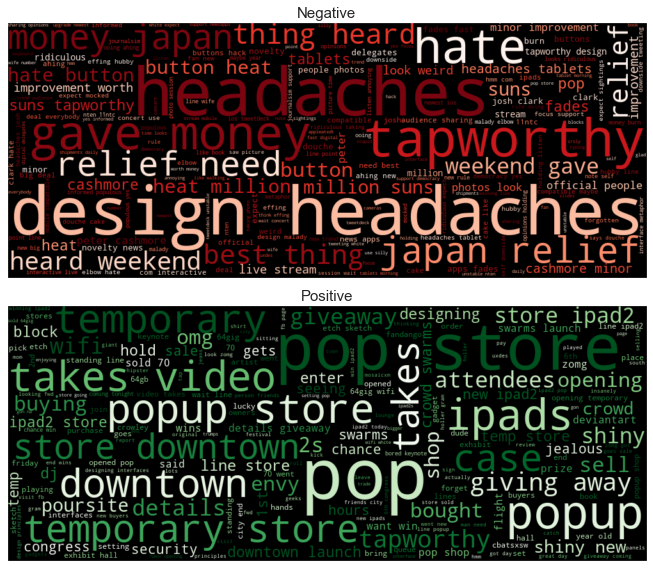

<IPython.core.display.Javascript object>

In [31]:
fig = plot_brand_clouds("iPad", "images/ipad_clouds.svg")

### iOS Apps

The negative chatter seems to focus on the short lifecycle of news apps, and is related to [this article](https://www.theguardian.com/technology/pda/2011/mar/15/sxsw-apple-ipad-news-apps) from the time period.

There are some complaints about apps using geolocation eating up battery life.

Holler Gram was a social media app which existed for use at South by Southwest, according [this article](https://www.forbes.com/sites/billbarol/2011/03/07/holler-gram-is-here/?sh=454ea1ed2a60).

These wordclouds don't seem to be as interesting as some of the others.

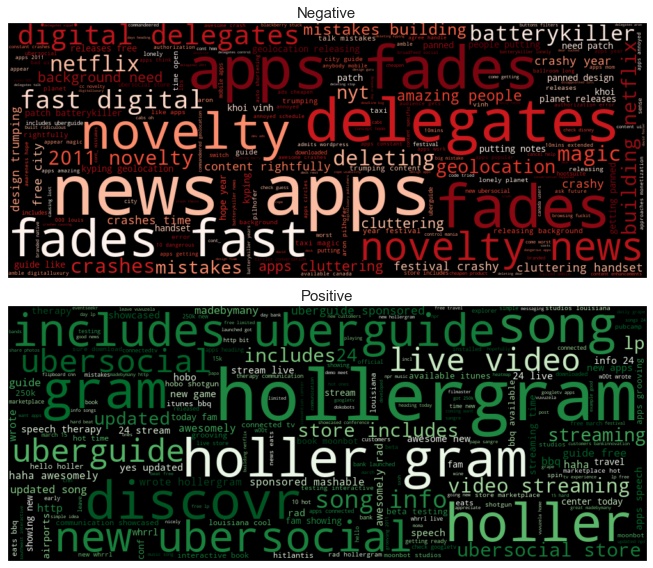

<IPython.core.display.Javascript object>

In [32]:
fig = plot_brand_clouds("iOS App", "images/ios_app_clouds.svg")

### Google

There appears to have been a Guardian article going around titled "The #Google and #Bing smackdown in all its bloody banality".

People were saying things like:

> So true!!! RT @mention 'Google lost its way by caring too much for the business vs. the users' - @mention #psych #sxsw

People seemed to be excited about a talk given by [Marissa Mayer](https://en.wikipedia.org/wiki/Marissa_Mayer). They were also anticipating the launch of Google Circles.


This mantra was being virally tweeted.

> RT @mention ���@mention "Google before you tweet" is the new "think before you speak." - Mark Belinsky, #911tweets panel at #SXSW.�۝

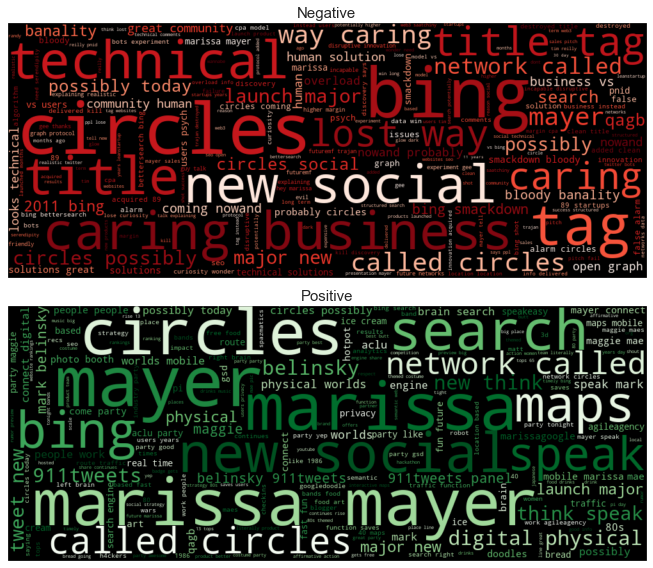

<IPython.core.display.Javascript object>

In [33]:
fig = plot_brand_clouds("Google", "images/google_clouds.svg")

### Android

The most interesting phrase here is "apps like ipod", which appears to originate from the following tweet:

 > @mention Android needs a way to group apps like you can now do with iPad/iPod. #SXSW #hhrs
 
There is also talk about bugginess, as in:

> Is it just me or has the @mention client for Android gotten really buggy lately? #SXSW to blame?

This is good news for Apple.

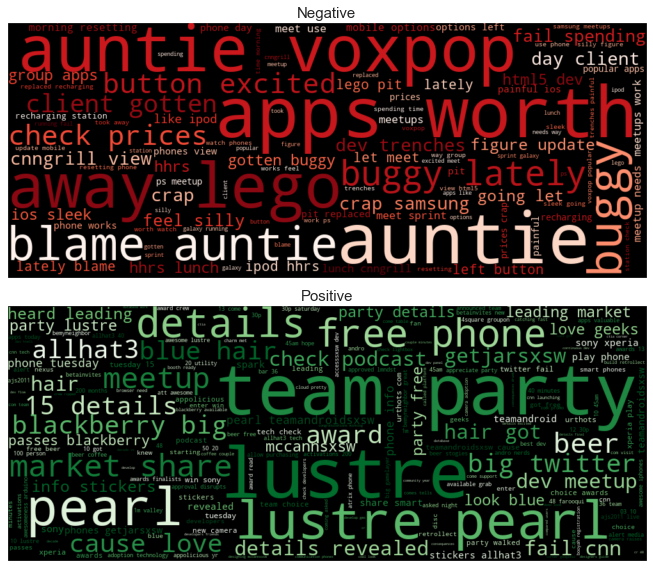

<IPython.core.display.Javascript object>

In [34]:
fig = plot_brand_clouds("Android", "images/android_clouds.svg")

### Android Apps

There were some complaints about the specific South by Southwest Android app.

> Beware, the android #sxsw app for schedules is completely innacurate. Just walked to the hyatt for no reason #sxswfail

A few people tweeted about this, although it doesn't seem particularly juicy:

> 95% of iPhone and Droid apps have less than 1,000 downloads total. #SXSW

There was a lot of cheering for Gowalla's app winning the Team Android Choice Awards:

> Nice! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw

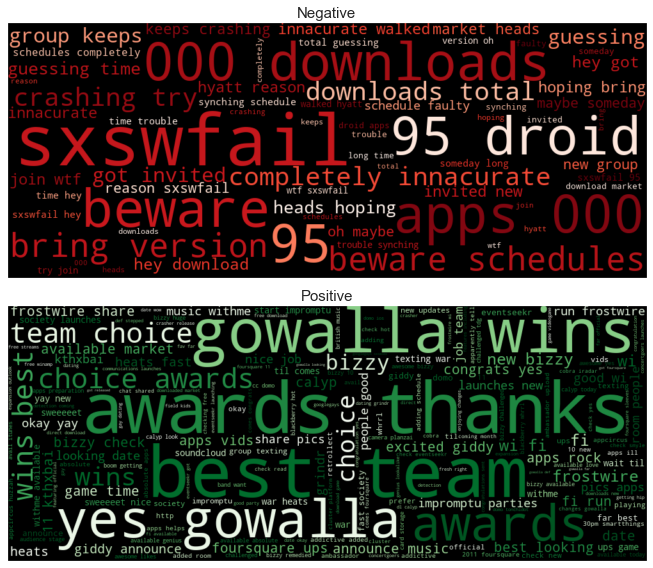

<IPython.core.display.Javascript object>

In [35]:
fig = plot_brand_clouds("Android App", "images/android_clouds.svg")

# Two Upshots

## You're Viewed as a Tyrant
People like that Apple products just work out of the box, but they find your paternalistic approach to managing your products off-putting. **Send the message** that when you buy an Apple product, you are free to do what you want with it. Keep control over the most important things, but relinquish control over the less important things. Make people feel like they have the freedom to customize your products as they see fit. Make some concessions to placate the majority, while allowing the elite techno-snobs to continue complaining on the fringe.

## Battery Life Needs Improvement
There were a lot complaints about the iPhone's battery life. One user suggested that their Blackberry was doing much better. There were also complaints about #batterykiller apps which use geolocation in the background. If you made a big publicized effort to increase the iPhone's battery life, that would get people excited.